# Thống kê Bayes sử dụng probflow
# Bài 2: Tương quan tuyến tính Pearson

### BS. Lê Ngọc Khả Nhi

Đây là bài thứ 2 trong loạt bài giới thiệu về thư viện probflow, ứng dụng làm thống kê Bayes trong Python. Nhắc lại: probflow là 1 giao thức của tensorflow và tensorflow probabilty, cho phép dựng mô hình Bayes.

Nội dung của bài này là phân tích tương quan Bayes. 

Hệ số tương quan Pearson ($\rho$) giữa 2 biến x,y được định nghĩa là:
    
$\rho_{x,y} = \frac{\text{cov} (x, y)}{\text{var}(x) ~ \text{var}(y)}$

Để mô hình hóa hệ số tương quan $\rho$, ta giả định covariance matrix $\Sigma$ được rút ra từ 
một phân bố Gaussian đa biến (multivariate normal distribution), có cấu trúc như sau:

$\begin{split}\Sigma =
\begin{bmatrix}
   \text{var}(x) & \text{cov}(x, y) \\
   \text{cov}(x,y) & \text{var}(y)\\
\end{bmatrix} =
\begin{bmatrix}
   \text{var}(x) & \rho ~ \text{var}(x) \text{var}(y) \\
   \rho ~ \text{var}(x) \text{var}(y) & \text{var}(y)\\
\end{bmatrix}\end{split}$

Trong trường hợp x và y ĐÃ được chuẩn hóa (phương sai của x và y đều = 1), ta có:

$\begin{split}\Sigma =
\begin{bmatrix}
   1 & \rho \\
   \rho & 1 \\
\end{bmatrix}\end{split}$

Khi đó diagonal của covariance matrix chính là $\rho$


# Bài toán minh họa

Giả dùng dataset breast_cancer của scikit-learn và rút ra 1 tập dữ liệu nhỏ gồm 6 biến:

In [1]:
# Cấu trúc dữ liệu
from sklearn import datasets
import numpy as np
import pandas as pd
from itertools import combinations
from collections import defaultdict

# Chuẩn hóa ma trận
import scipy.stats as ss

# Đồ họa
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# probflow và tf

import probflow as pf
import tensorflow as tf

In [17]:
df = datasets.load_breast_cancer()
df = pd.DataFrame(df['data'], columns=df['feature_names']).iloc[:,[0,1,4,5,7,8]]
df.columns = ['RAD','TEX','SM','COM','CP','SYM']

df.head(5)

,RAD,TEX,SM,COM,CP,SYM
0,17.99,10.38,0.11840,0.27760,0.14710,0.2419
1,20.57,17.77,0.08474,0.07864,0.07017,0.1812
2,19.69,21.25,0.10960,0.15990,0.12790,0.2069
3,11.42,20.38,0.14250,0.28390,0.10520,0.2597
4,20.29,14.34,0.10030,0.13280,0.10430,0.1809


In [22]:
var_names

Index(['RAD', 'TEX', 'SM', 'COM', 'CP', 'SYM'], dtype='object')

In [69]:
var_names = df.columns

X = df.values

X.shape

(569, 6)

In [71]:
X

array([[17.99   , 10.38   ,  0.1184 ,  0.2776 ,  0.1471 ,  0.2419 ],
       [20.57   , 17.77   ,  0.08474,  0.07864,  0.07017,  0.1812 ],
       [19.69   , 21.25   ,  0.1096 ,  0.1599 ,  0.1279 ,  0.2069 ],
       ...,
       [16.6    , 28.08   ,  0.08455,  0.1023 ,  0.05302,  0.159  ],
       [20.6    , 29.33   ,  0.1178 ,  0.277  ,  0.152  ,  0.2397 ],
       [ 7.76   , 24.54   ,  0.05263,  0.04362,  0.     ,  0.1587 ]])

# Phân tích tương quan Bayes dùng probflow

## Bước 1:

Trước tiên, ta tạo class mô hình BayesianCorrelation, nội dung là xác định phân phối hậu nghiệm của tham số rho trong khoảng -1:1; dựa vào covariance matrix của một dataframe dữ liệu 2 biến, theo phân bố Multivariate Normal.

In [19]:
class BayesianCorrelation(pf.Model):

    def __init__(self):
        self.rho = pf.BoundedParameter(min=-1, max=1, name = 'rho')

    def __call__(self):
        cov = tf.eye(2) + self.rho()*tf.abs(tf.eye(2)-1)
        return pf.MultivariateNormal(tf.zeros([2]), cov)

## Bước 2: Tạo danh sách mô hình bắt cặp tuần tự giữa 6 biến 

Nhi dùng method combinations của module itertools để tạo ra 1 iterator tên là comb, trong đó bắt cẵp tuần tự (không lặp lại) giữa 2 trong 6 biến;

Có 15 cặp tương quan được tạo ra, tương ứng với vị trí của 2 biến trong array X

In [91]:
comb = combinations(range(len(var_names)),2)

for i in comb:
    print(i)

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 3)
(2, 4)
(2, 5)
(3, 4)
(3, 5)
(4, 5)


Tiếp theo, Nhi viết 1 vòng lặp for, để lần lượt dựng 15 mô hình BayesianCorrelation() cho 15 cặp 2 biến trong danh sách comb. 

Cho mỗi cặp, ta tạo ra 1 array 2D x, chứa 2 biến đã được chuẩn hóa thành thang đo z-scores, sau đó train 1 mô hình, và lưu kết quả của mô hình vào dictionary mod_dict

Quá trình train 15 mô hình có thể khá chậm, nhất là khi bạn muốn train nhiều epochs, ở đây Nhi chỉ làm minh họa:

In [77]:
comb = combinations(range(len(var_names)),2)
mod_dict = defaultdict()

for i in comb:
    mod = BayesianCorrelation()
    
    x = np.array(ss.zscore(X[:,i]))
        
    mod.fit(x,lr=0.1)
    
    mod_dict[i] = mod

2020-05-16 12:27:56.555216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1304] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6354 MB memory) -> physical GPU (device: 0, name: GeForce GTX 1080 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1)

2020-05-16 12:27:57.217211: I tensorflow/core/kernels/cuda_solvers.cc:159] Creating CudaSolver handles for stream 00000218B189C130

2020-05-16 12:27:57.234600: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cusolver64_100.dll

2020-05-16 12:27:57.616654: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_100.dll

Đây là nội dung mod_dict sau khi hoàn tất, ta có 15 mô hình:

In [78]:
mod_dict

defaultdict(None,
            {(0, 1): <__main__.BayesianCorrelation at 0x21a8a01df08>,
             (0, 2): <__main__.BayesianCorrelation at 0x21a8cb54108>,
             (0, 3): <__main__.BayesianCorrelation at 0x21a8a0209c8>,
             (0, 4): <__main__.BayesianCorrelation at 0x21a8d68e748>,
             (0, 5): <__main__.BayesianCorrelation at 0x21a8a00cbc8>,
             (1, 2): <__main__.BayesianCorrelation at 0x21a89e26888>,
             (1, 3): <__main__.BayesianCorrelation at 0x21a89f08148>,
             (1, 4): <__main__.BayesianCorrelation at 0x21a8d72d9c8>,
             (1, 5): <__main__.BayesianCorrelation at 0x21a822bdb88>,
             (2, 3): <__main__.BayesianCorrelation at 0x21a8cfc2688>,
             (2, 4): <__main__.BayesianCorrelation at 0x21a8db2cc08>,
             (2, 5): <__main__.BayesianCorrelation at 0x21a824be208>,
             (3, 4): <__main__.BayesianCorrelation at 0x21a89a44908>,
             (3, 5): <__main__.BayesianCorrelation at 0x21a80bb8888>,
  

In [79]:
len(mod_dict)

15

## Bước 3: Lấy mẫu MCMC của rho cho từng cặp tương quan

Tiếp theo, Nhi dùng 1 vòng lặp for khác để lấy lần lượt 15 x 5 chuỗi MCMC, mỗi chuỗi dài 1000 lượt cho 15 cặp tương quan, và lưu kết quả vào dictionary rho_dict

In [80]:
rho_dict = defaultdict()

for i in mod_dict.keys():
    pair_name = var_names[i[0]] + '/' + var_names[i[1]]
    
    rho_dict[pair_name] = mod_dict[i].posterior_sample(n=5000)\
    ['rho'].flatten().reshape(5,1000)

In [81]:
rho_dict.keys()

dict_keys(['RAD/TEX', 'RAD/SM', 'RAD/COM', 'RAD/CP', 'RAD/SYM', 'TEX/SM', 'TEX/COM', 'TEX/CP', 'TEX/SYM', 'SM/COM', 'SM/CP', 'SM/SYM', 'COM/CP', 'COM/SYM', 'CP/SYM'])

## Bước 4: Suy diễn thống kê bằng arviz

Nhi chuyển rho_dict thành object dữ liệu arviz để có thể dùng arviz vẽ hình, làm bảng thống kê:

In [82]:
rho_traces = az.from_dict(rho_dict)

### Chuỗi MCMC của 15 giá trị rho 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A91141888>,
      dtype=object)

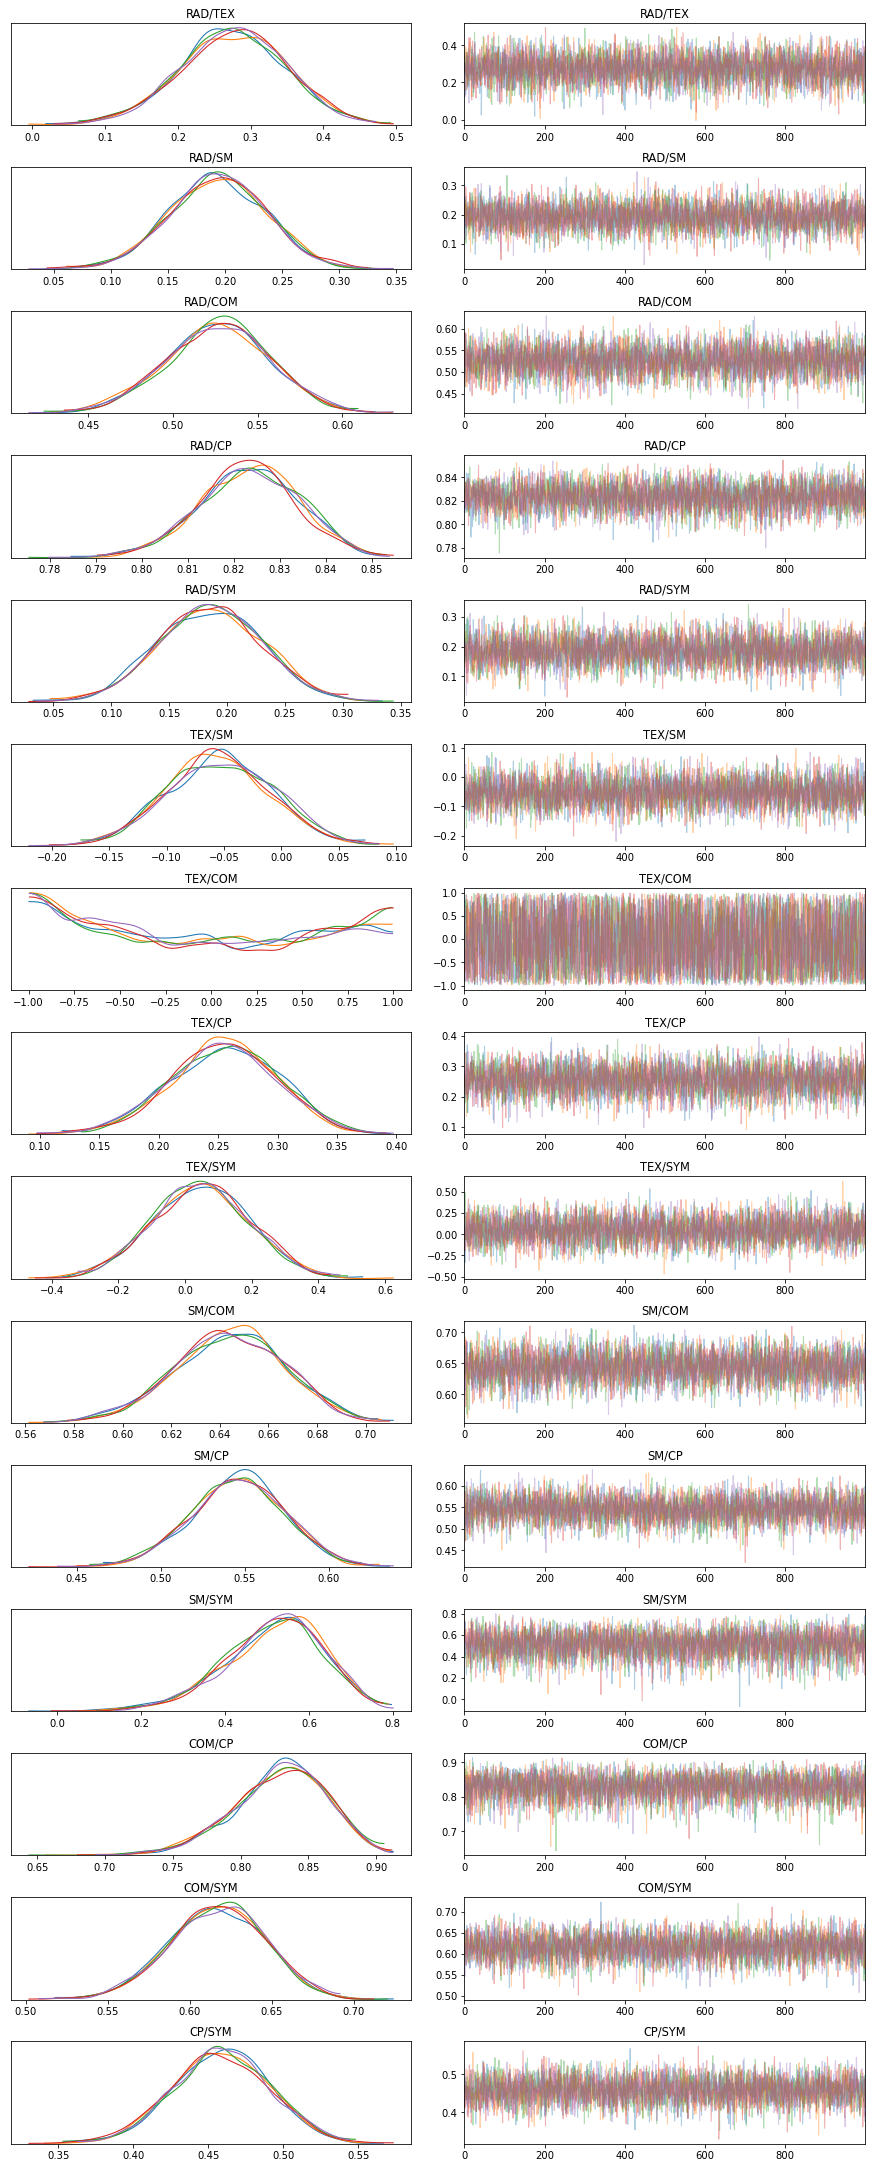

In [90]:
az.plot_trace(rho_traces, compact=False)

### Phân phối hậu nghiệm của 15 rho

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A8ACE2F48>,
      dtype=object)

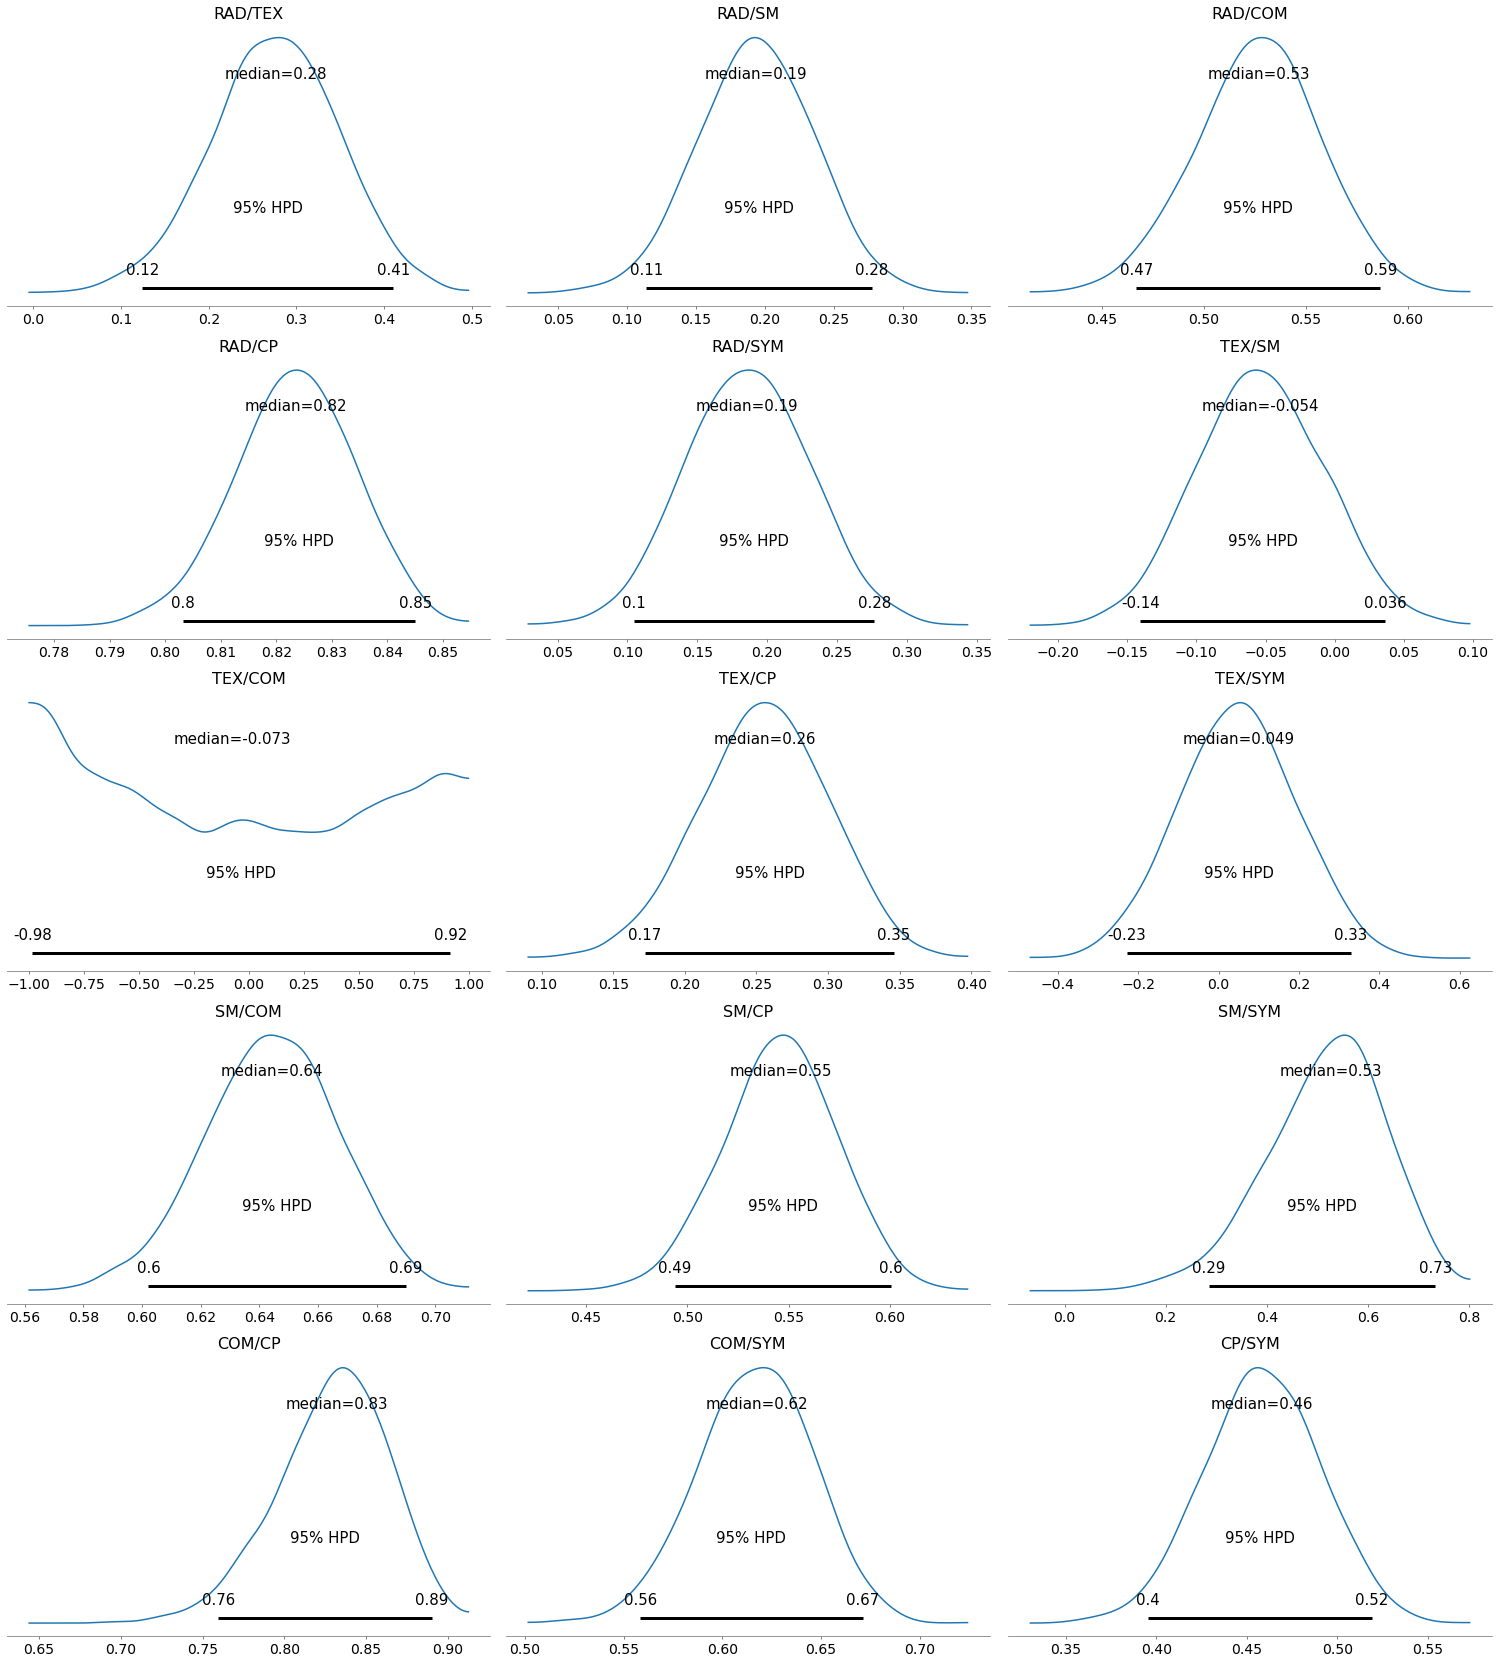

In [84]:
az.plot_posterior(rho_traces,
                   point_estimate='median', 
                   credible_interval = 0.95)

### Biểu đồ Forest-plot

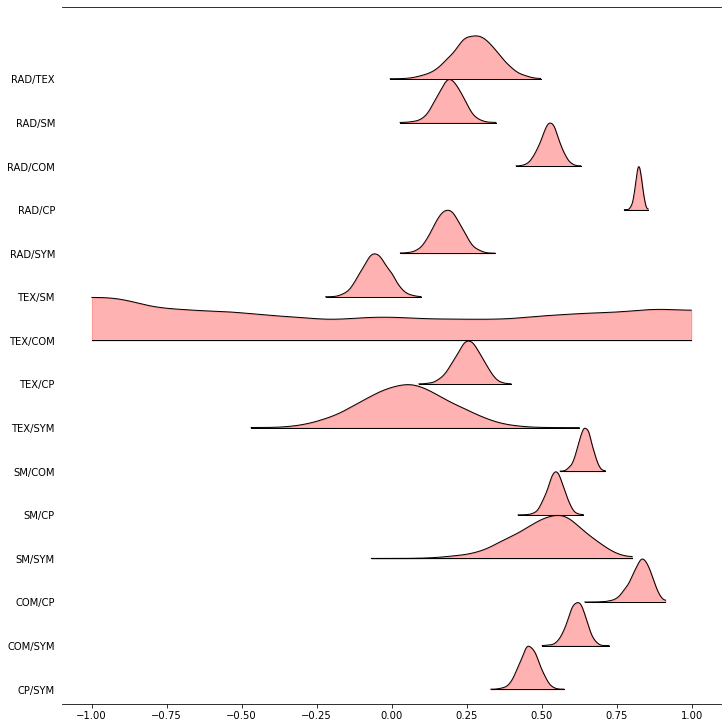

In [86]:
az.plot_forest(rho_traces,
               kind='ridgeplot',
               colors= 'red',
               ridgeplot_alpha = 0.3,
               linewidth=1,
               combined=True,
               credible_interval = 0.95,
               ridgeplot_overlap=1.,
               figsize=(10, 10));

### Bảng tóm tắt kết quả

In [94]:
az.summary(rho_traces, 
           credible_interval=0.95, 
           kind = 'stats',
          stat_funcs={'Median': np.median})

,mean,sd,hpd_2.5%,hpd_97.5%,Median
RAD/TEX,0.275,0.073,0.124,0.410,0.277
RAD/SM,0.194,0.042,0.114,0.278,0.194
RAD/COM,0.527,0.031,0.467,0.586,0.527
RAD/CP,0.823,0.011,0.803,0.845,0.823
RAD/SYM,0.186,0.044,0.104,0.277,0.186
TEX/SM,-0.054,0.046,-0.140,0.036,-0.054
TEX/COM,-0.047,0.621,-0.984,0.916,-0.073
TEX/CP,0.255,0.045,0.172,0.346,0.256
TEX/SYM,0.048,0.144,-0.228,0.329,0.049
SM/COM,0.644,0.023,0.602,0.690,0.644


# Bonus: Đối chiếu với phân tích tương quan frequentist:

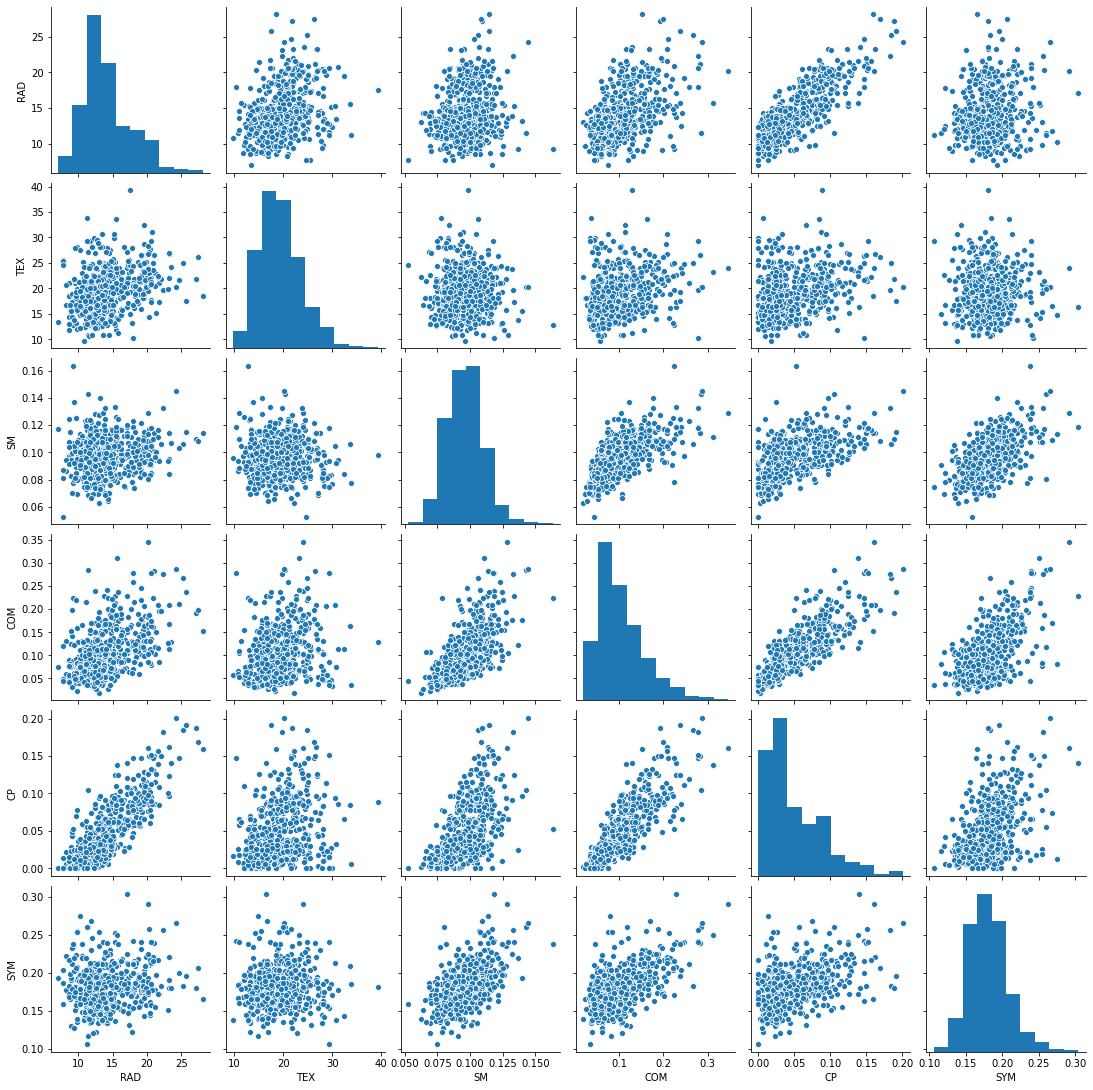

In [73]:
sns.pairplot(df)

In [102]:
def correlation_matrix(df = None, method = 'pearson'):
    
    '''
    Hàm thực hiện phân tích tương quan
    # Input: pandas dataframe 
    # Arguments: df = pandas dataframe chứa datatype là int hoặc float
                 method = string, giá trị có thể: 'pearson', 'spearman'
    # Output: 2 matrices r và p_vals
    '''
    
    from scipy.stats import pearsonr
    import itertools
    
    corr = df.corr(method = method)
    pvals = np.ones_like(corr)
    
    m = df.values
    m = np.array(ss.zscore(m))
    
    n = df.shape[1]
    
    out = [pearsonr(m[:,i],m[:,j])+(i, j) for i, j in itertools.product(range(n), range(n))]
    
    for i in out:
        pvals[i[2],i[3]] = i[1]
    
    pvals = pd.DataFrame(pvals, columns=corr.columns, index = corr.index)
    
    return corr, pvals

In [103]:
corr, pvals = correlation_matrix(df)

corr

,RAD,TEX,SM,COM,CP,SYM
RAD,1.000000,0.323782,0.170581,0.506124,0.822529,0.147741
TEX,0.323782,1.000000,-0.023389,0.236702,0.293464,0.071401
SM,0.170581,-0.023389,1.000000,0.659123,0.553695,0.557775
COM,0.506124,0.236702,0.659123,1.000000,0.831135,0.602641
CP,0.822529,0.293464,0.553695,0.831135,1.000000,0.462497
SYM,0.147741,0.071401,0.557775,0.602641,0.462497,1.000000


In [106]:
pvals

,RAD,TEX,SM,COM,CP,SYM
RAD,0.000000e+00,2.360374e-15,4.312577e-05,2.414237e-38,4.350747e-141,4.064650e-04
TEX,2.360374e-15,0.000000e+00,5.776966e-01,1.095581e-08,9.153223e-13,8.882926e-02
SM,4.312577e-05,5.776966e-01,0.000000e+00,3.403822e-72,5.043590e-47,7.795253e-48
COM,2.414237e-38,1.095581e-08,3.403822e-72,0.000000e+00,1.240590e-146,1.524162e-57
CP,4.350747e-141,9.153223e-13,5.043590e-47,1.240590e-146,0.000000e+00,1.676645e-31
SYM,4.064650e-04,8.882926e-02,7.795253e-48,1.524162e-57,1.676645e-31,0.000000e+00


In [105]:
pvals < 0.05

,RAD,TEX,SM,COM,CP,SYM
RAD,True,True,True,True,True,True
TEX,True,True,False,True,True,False
SM,True,False,True,True,True,True
COM,True,True,True,True,True,True
CP,True,True,True,True,True,True
SYM,True,False,True,True,True,True
